## 获取数据

In [ ]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

In [ ]:
df.iloc[:,:-1]

## 输入输出

In [ ]:
mem_his_days=5
per_days=10
df.dropna(inplace=True)
df.sort_index(inplace=True)

df['label'] = df['Close'].shift(-per_days)

In [ ]:
# def stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=10):
# mem_his_days=5
# per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# df['label'] = df['Close'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-1])
# sca_X = np.array(df.iloc[:,:-1])
# print(sca_X)

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))



X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)

    # return X,y,X_lately

In [ ]:
sca_X

In [ ]:
X

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# sca_X = scaler.fit_transform(df.iloc[:,:-1])
# # sca_X = df.iloc[:,:-1]
# print(sca_X)

In [ ]:
# X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=50)

In [ ]:
print(len(X))
print(len(y))
print(len(X_lately))

In [ ]:
X[0]

# LSTM

## 参数寻优

In [ ]:
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dens_layers = [1,2,3]
# units = [8,16,32]
mem_days = [5]
lstm_layers = [1]
dens_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dens_layers in dens_layers:
            for the_units in units:
                # save model
                filepath = '{val_mape:.2f}_{epoch:02d}'+f'_mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dens_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)
                # print(filepath)
                X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=the_mem_days,per_days=10)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
            
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dens_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                # model.summary()
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=50,
                          validation_data=(X_test,y_test),
                          callbacks=[checkpoint])

                

## 构建网络

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
model = Sequential(name="lstm_m5_p10")
model.add(LSTM(32,input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

## 读取推理

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('E:\\Document\\Timing-signal-analysis\\lstm_3.90_18_mem_5_lstm_1_dense_1_unit_32')
best_model.summary()

In [ ]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(pre.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,pre,color='red',label='predict')
plt.show()

# ENN

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

## 构建网络

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.regularizers import l1_l2

# alpha是正则化项的强度，l1_ratio是L1正则化相对于L2的比例
alpha = 0.01
l1_ratio = 0.5
regularizer = l1_l2(l1=alpha * l1_ratio, l2=alpha * (1 - l1_ratio))

model = Sequential(name="ENN")
model.add(Dense(32, activation='relu', input_shape=X.shape[1:], kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32,activation='relu',kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear', kernel_regularizer=regularizer))
model.summary()

In [ ]:
X.shape[1:]

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

## 推理

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# WNN

In [ ]:
from sklearn.model_selection import train_test_split
import pywt  # 小波变换库

coefficients = pywt.wavedec2(X, 'db1', level=1)  # 使用db1小波和一层分解
input_shape = coefficients[0].shape  # 更新输入形状以匹配小波变换后的数据
X_train,X_test,y_train,y_test = train_test_split(coefficients[0],y,test_size=0.1)

## 构建网络

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.regularizers import l1_l2

# coefficients = pywt.wavedec2(X, 'db1', level=1)  # 使用db1小波和一层分解
# input_shape = coefficients[0].shape  # 更新输入形状以匹配小波变换后的数据

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape[1:]))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

## 推理

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# RBFNN 待续

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda,Layer
from tensorflow.keras.layers import Wrapper
from tensorflow.keras.optimizers import Adam

class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma
        # 将RBF中心初始化为输入的均值（或随机值）
        self.centers = self.add_weight(name='centers',
                                       shape=(units,),
                                       initializer='zeros',
                                       trainable=True)

    def call(self, inputs):
        # 计算输入和中心之间的差的平方和
        squared_diff = tf.reduce_sum(tf.square(inputs[:, None, :] - self.centers[None, :, :]), axis=-1)
        # 应用径向基函数
        return tf.exp(-self.gamma * squared_diff)

    def compute_output_shape(self, input_shape):
        # 输出形状与输入样本数相同
        return (input_shape[0], self.units)

In [ ]:
model = Sequential()
model.add(RBFLayer(Dense(64), gamma=0.5, input_shape=(25,)))
model.add(Dense(1),activation='linear')
model.summary()


In [ ]:

X_train.shape

In [ ]:
rbf_matrix.shape

# LS-SVM

In [ ]:
from sklearn.model_selection import train_test_split
X_flattened = X.reshape(X.shape[0], -1)  # (样本数, 25)
X_train,X_test,y_train,y_test = train_test_split(X_flattened,y,test_size=0.1)

In [ ]:
X_flattened.shape

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 创建LS-SVM回归模型
# 创建LS-SVM回归模型，使用RBF核函数
model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# ZNN

In [ ]:
import pandas as pd

filename = 'data\electricity_cleaned.txt'
data_frame = pd.read_csv(filename, header=None)

# 将DataFrame转换为NumPy数组
matrix = data_frame.values
print(matrix.shape)
print(matrix)

## 评价指标

In [12]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def model_evaluation(y_true, y_pred):
    # 均方误差（MSE）
    mse = mean_squared_error(y_true, y_pred)
    # 均方根误差（RMSE）
    rmse = np.sqrt(mse)
    # 平均绝对误差（MAE）
    mae = mean_absolute_error(y_true, y_pred)
    # R平方（R2）
    r2 = r2_score(y_true, y_pred)
    # 解释方差得分（Explained Variance Score）
    explained_variance = explained_variance_score(y_true, y_pred)
    return mse,rmse,mae,r2,explained_variance



## 预测控制

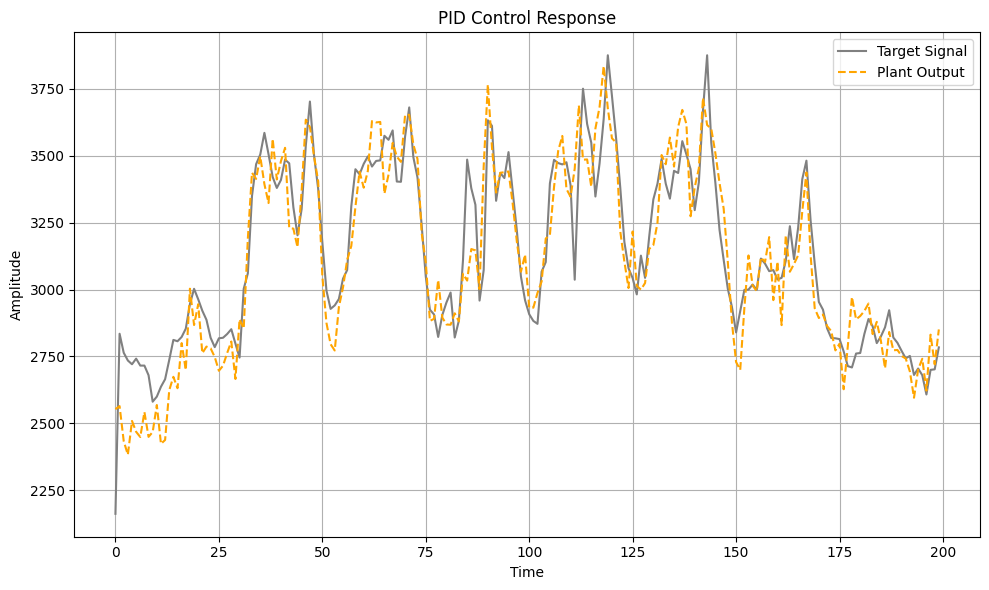

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class PlantModel:
    def __init__(self,time_constant=10.0):
        self.time_constant = time_constant

    def response(self, control_input, previous_output):
        model_response = previous_output + (control_input - previous_output) / self.time_constant
        model_response += 100*np.random.randn()
        return model_response

class PIDController:
    def __init__(self, Kp=5.0, Ki=0.5, Kd=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def control(self, reference_signal, model_response):
        error = reference_signal - model_response
        self.integral += error
        derivative = error - self.prev_error
        control_signal = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return control_signal

def target_function(step):
    # 定义控制目标函数
    filename = 'data\electricity_cleaned.txt'
    data_frame = pd.read_csv(filename, header=None)
    matrix = data_frame.values
    target_signal = matrix[step,0]
    return target_signal   

if __name__ == "__main__":
    # 创建被控对象
    plant_model = PlantModel()
    # 创建PID控制器
    pid_controller = PIDController()
    # 模拟过程
    steps = 200
    time = np.arange(steps)
    ref_signals = [target_function(step) for step in time]

    predicts = [1]
    for pre_step in predicts:
        model_responses = [2500]
        control_signals = []
        for step in range(steps):
            control_signal = pid_controller.control(target_function(step+pre_step), model_responses[-1])
            control_signals.append(control_signal)
            model_response = plant_model.response(control_signal, model_responses[-1])
            model_responses.append(model_response)
        # print('pre_step:%d'%pre_step,model_evaluation(ref_signals,model_responses[1:]))

    plt.figure(figsize=(10, 6))
    plt.plot(time, ref_signals, label='Target Signal', color='gray')
    plt.plot(time, model_responses[1:], label='Plant Output', linestyle='--', color='orange')
    # plt.plot(time, control_signals, label='Controlled Output', linestyle='-', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('PID Control Response')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 动力学模型

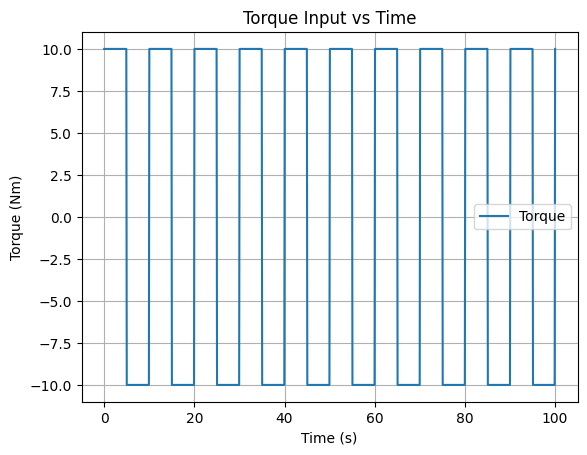

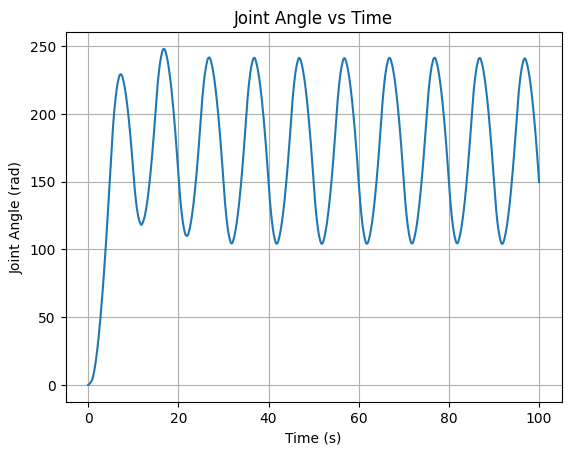

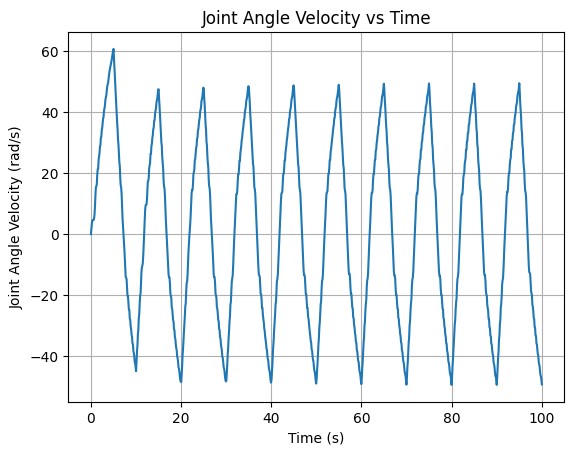

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def torque_function(t):
    # 生成扭矩函数
    period = 10
    amplitude = 10
    duty_cycle = 0.5
    t_in_period = t % period
    if t_in_period < period * duty_cycle:
        return amplitude
    else:
        return -amplitude

class PlantModel:
    def __init__(self, initial_angle=0.0, initial_angular_velocity=0.0):
        self.initial_angle = initial_angle
        self.initial_angular_velocity = initial_angular_velocity
        
    def dynamics(self, theta, t, torque_function):
        # 这里假设系统为单自由度（单个关节），所以只有一个状态变量theta
        # torque是关节扭矩，t是时间
        torque = torque_function(t)
        # 系统参数
        m = 1.0  # 质量
        l = 1.0  # 长度
        g = 9.81  # 重力加速度
        friction_coefficient = 0.1 # 摩擦系数
        inertia = 0.5 # 惯性
        # 动力学方程
        theta_dot = theta[1]
        theta_dot_dot = (torque - friction_coefficient * theta[1] - m * g * l * np.sin(theta[0])) / inertia
        return [theta_dot, theta_dot_dot]

    def simulate(self, current_angle, current_angular_velocity, t_list,torque_function):
        # 模拟函数，模拟关节角度随时间的变化
        # 初始条件
        theta_initial = [current_angle, current_angular_velocity]  # 初始角度和初始角速度
        # 使用odeint求解微分方程
        theta = odeint(self.dynamics, theta_initial, t_list, args=(torque_function,))
        # 返回角度、角速度随时间的变化
        return theta

# 使用
initial_angle = 0.0
initial_angular_velocity = 0.0
plant = PlantModel(initial_angle, initial_angular_velocity)

# 假设当前角度和角速度
current_angle = initial_angle
current_angular_velocity = initial_angular_velocity

# 模拟关节角度随时间的变化
t_list = np.linspace(0, 100, 1000)  # 时间从0到100秒，共1000个时间步长
torque_values = [torque_function(ti) for ti in t_list]
angles = plant.simulate(current_angle, current_angular_velocity, t_list,torque_function)

# 绘制扭矩输入序列
plt.plot(t_list, torque_values, label='Torque')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque Input vs Time')
plt.grid(True)
plt.legend()
plt.show()

# 绘制关节角度随时间的变化
plt.plot(t_list, angles[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angle vs Time')
plt.grid(True)
plt.show()

# 绘制关节角速度随时间的变化
plt.plot(t_list, angles[:,1])
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle Velocity (rad/s)')
plt.title('Joint Angle Velocity vs Time')
plt.grid(True)
plt.show()


## 动力学模型控制仿真

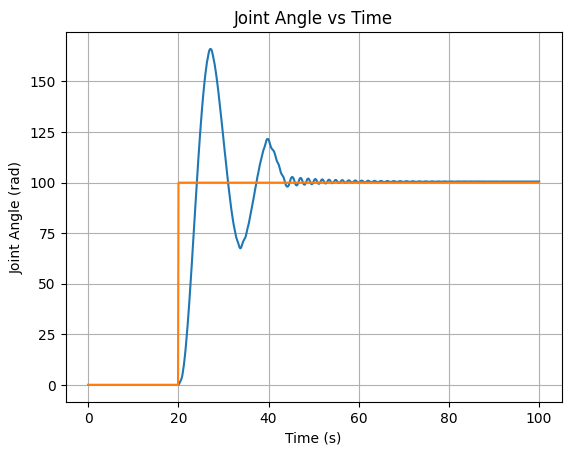

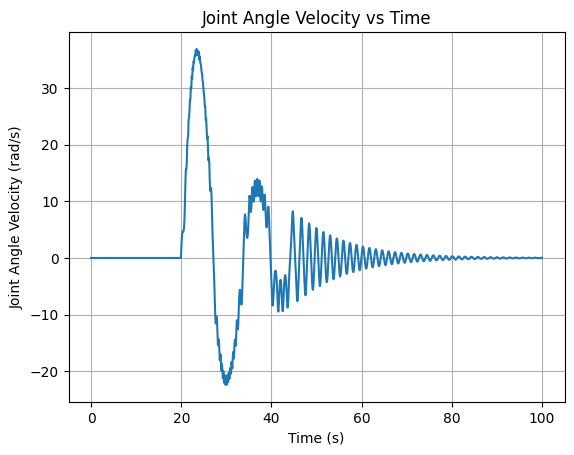

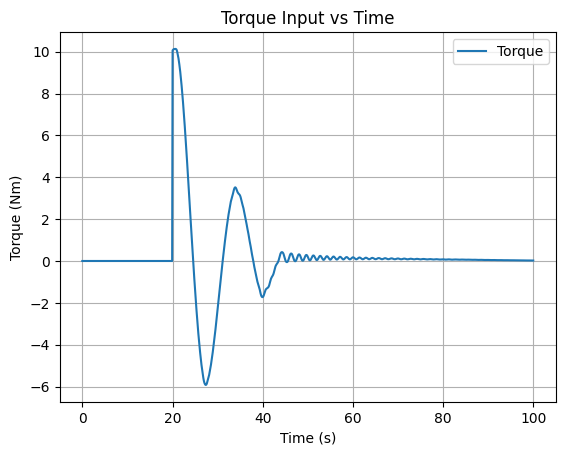

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

def target_function(t):
    # 控制目标函数
    target_signal = 100 if t>20 else 0

    return target_signal 

def activation_function(matrix):
    return np.maximum(0, matrix)

class PIDController:
    def __init__(self, Kp=1.0, Ki=0.5, Kd=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def control(self, reference_signal, model_response):
        error = reference_signal - model_response
        self.integral += error
        derivative = error - self.prev_error
        control_signal = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return control_signal

class PlantModel:
    def __init__(self, initial_angle=0.0, initial_angular_velocity=0.0):
        self.initial_angle = initial_angle
        self.initial_angular_velocity = initial_angular_velocity
        
    def dynamics(self, t, theta, torque):
        # 系统参数
        m = 1.0  # 质量
        l = 1.0  # 长度
        g = 9.81  # 重力加速度
        friction_coefficient = 0.1 # 摩擦系数
        inertia = 0.5 # 惯性
        
        # 动力学方程
        theta_dot = theta[1]
        theta_dot_dot = (torque - friction_coefficient * theta[1] - m * g * l * np.sin(theta[0])) / inertia
        return [theta_dot, theta_dot_dot]

    def simulate(self, current_angle, current_angular_velocity, t_list, torque_function):
        # 模拟函数，模拟关节角度随时间的变化
        # 初始条件
        theta_initial = [current_angle, current_angular_velocity]  # 初始角度和初始角速度
        
        # 创建ode对象
        solver = ode(self.dynamics).set_integrator('dopri5')
        solver.set_initial_value(theta_initial, t_list[0])
        
        # 存储结果
        angles = [theta_initial]
        torque_values = [0]
        
        # 模拟关节角度随时间的变化
        for t_next in t_list[1:]:
            # 计算扭矩，扭矩等于控制器输出
            torque = torque_function(target_function(t_next), angles[-1][0])
            torque_values.append(torque)
            
            # 求解微分方程
            solver.set_f_params(torque)
            solver.integrate(t_next)
            angles.append(solver.y)
        
        return np.array(angles), np.array(torque_values)

# 动力学模型初始化
initial_angle = 0.0
initial_angular_velocity = 0.0
plant = PlantModel(initial_angle, initial_angular_velocity)

# 控制器初始化
pid_controller = PIDController(Kp=0.1, Ki=5e-4, Kd=1e-4)

# 假设当前角度和角速度
current_angle = initial_angle
current_angular_velocity = initial_angular_velocity

# 模拟关节角度随时间的变化
t_list = np.linspace(0, 100, 1000)  # 时间从0到100秒，共1000个时间步长
ref_signals = [target_function(t) for t in t_list]

angles, torque_values = plant.simulate(current_angle, current_angular_velocity, t_list, pid_controller.control)

# 绘制关节角度随时间的变化
plt.plot(t_list, angles[:,0])
plt.plot(t_list, ref_signals, label='Target Signal')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angle vs Time')
plt.grid(True)
plt.show()

# 绘制关节角速度随时间的变化
plt.plot(t_list, angles[:,1])
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle Velocity (rad/s)')
plt.title('Joint Angle Velocity vs Time')
plt.grid(True)
plt.show()

# 绘制扭矩输入序列
plt.plot(t_list, torque_values, label='Torque')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque Input vs Time')
plt.grid(True)
plt.legend()
plt.show()


## ZNN求解

In [88]:
# 求解时变线性矩阵方程
import numpy as np

# 定义激活函数，这里使用ReLU函数
def activation_function(matrix):
    return np.maximum(0, matrix)

# 定义ZNN的更新规则
def znn_update(X, A, B, C, A_dot, B_dot, C_dot, gamma):
    # 计算误差矩阵 E(t) = A(t)X(t)B(t) + X(t) - C(t)
    error = A @ X @ B + X - C
    # 假设我们已经有了误差矩阵的时间导数 _E(t)
    error_dot = A_dot @ X @ B + A @ X @ B_dot + A @ X @ B + X - C_dot
    # 使用激活函数处理误差矩阵
    F_error = activation_function(error)
    # 更新规则 _X(t) = -γ * (∇E/∇X)
    X_dot = -gamma * (A_dot @ F_error @ B + A @ F_error @ B_dot + A @ F_error @ B + F_error)
    return X + X_dot

# ZNN主函数
def znn_solve(A, B, C, A_dot, B_dot, C_dot, gamma=0.1, max_iterations=1000, tolerance=1e-6):
    X = np.eye(A.shape[1])  # 初始猜测为单位矩阵
    for i in range(max_iterations):
        X_new = znn_update(X, A, B, C, A_dot, B_dot, C_dot, gamma)
        if np.linalg.norm(X_new - X) < tolerance:  # 检查是否收敛
            return X_new
        X = X_new
    return X

# 示例：使用ZNN解决时变线性矩阵方程
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
C = np.array([[9, 10], [11, 12]])
A_dot = np.zeros_like(A)  # 示例中假设时间导数为零
B_dot = np.zeros_like(B)
C_dot = np.zeros_like(C)
gamma = 0.1

# 求解矩阵方程
X_solution = znn_solve(A, B, C, A_dot, B_dot, C_dot, gamma)
print("Solution X:\n", X_solution)

Solution X:
 [[-100.6 -118.2]
 [-218.1 -253.1]]


In [92]:
import numpy as np

# 定义 ZNN 辨识器的更新规则
def znn_update(X, A, B, C, A_dot, B_dot, C_dot, gamma):
    error = A @ X @ B + X - C
    error_dot = A_dot @ X @ B + A @ X @ B_dot + A @ X @ B + X - C_dot
    F_error = np.maximum(0, error)
    X_dot = -gamma * (A_dot @ F_error @ B + A @ F_error @ B_dot + A @ F_error @ B + F_error)
    return X + X_dot

# ZNN 主函数
def znn_solve(A, B, C, A_dot, B_dot, C_dot, gamma=0.1, max_iterations=1000, tolerance=1e-6):
    X = np.eye(A.shape[1])  # 初始化猜测为单位矩阵
    for i in range(max_iterations):
        X_new = znn_update(X, A, B, C, A_dot, B_dot, C_dot, gamma)
        if np.linalg.norm(X_new - X) < tolerance:  # 检查是否收敛
            return X_new
        X = X_new
    return X

# 示例：使用 ZNN 辨识器作为控制器来控制一个简单的系统
# 系统模型（假设已知）
A_system = np.array([[0.5, 0.2], [-0.1, 0.3]])  # 系统状态方程的系数矩阵
B_system = np.array([[1], [0.5]])              # 输入系数矩阵
C_system = np.array([[1, 0], [0, 1]])          # 输出矩阵

# ZNN 辨识器参数（初始设定）
A_dot = np.zeros_like(A_system)
B_dot = np.zeros_like(B_system)
C_dot = np.zeros_like(C_system)
gamma = 0.1

# 设定期望输出
desired_output = np.array([[2], [1]])

# 控制器主循环
for t in range(100):
    # 使用 ZNN 辨识器估计系统动态特性
    X_estimate = znn_solve(A_system, B_system, C_system, A_dot, B_dot, C_dot, gamma)

    # 计算控制信号（假设为期望输出与实际输出的差）
    control_signal = desired_output - C_system

    # 使用控制信号控制系统
    # 这里可以将控制信号发送到系统，并获取实际输出

    # 在每个控制周期内更新 ZNN 辨识器参数
    # 这里可以根据实际输出和期望输出计算误差，并使用 ZNN 辨识器进行参数更新

    # 打印控制信号
    print("Control signal:", control_signal)


Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control signal: [[1 2]
 [1 0]]
Control 

# SSM

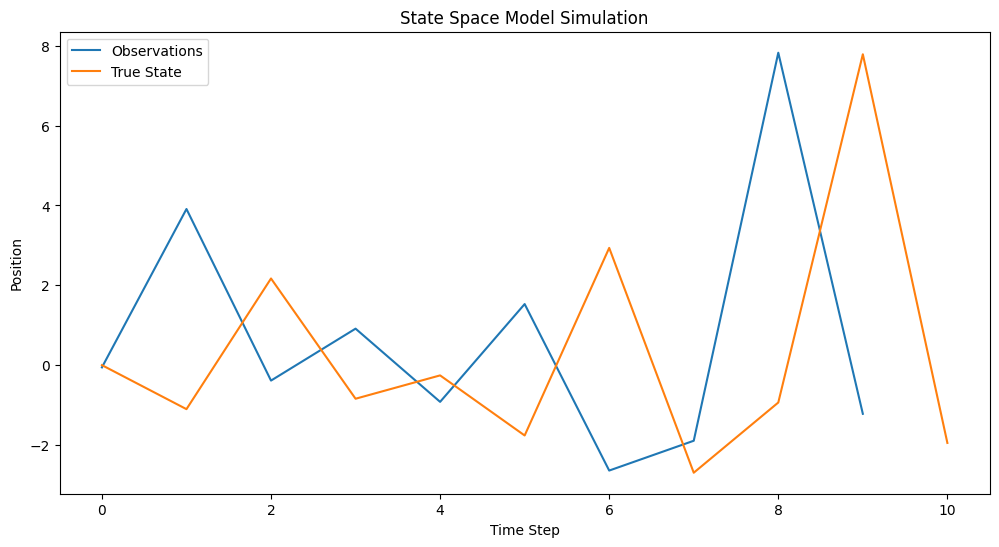

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 定义时间步长
dt = 0.1

# 定义状态转移矩阵 A 和输入矩阵 B
A = np.array([[1.0, dt],
              [0.0, 1.0]])
B = np.array([[0.5 * dt**2],
              [dt]])

# 定义观测矩阵 C 和观测噪声矩阵 D
C = np.array([[1.0, 0.0]])
D = np.array([[0.0]])

# 定义初始状态和初始状态协方差
x0 = np.array([0.0, 0.0])
P0 = np.eye(2)

# 模拟过程，例如10个时间步长
num_steps = 10

# 用于存储状态和观测结果的列表
states = [x0]
observations = []

for t in range(num_steps):
    # 状态转移
    x = A @ x0 + np.random.multivariate_normal([0, 0], P0)
    states.append(x)
    
    # 观测
    y = C @ x + np.random.normal(0, 1)
    observations.append(y)
    
    # 更新状态协方差矩阵 P0（这里简化处理，实际应用中需要考虑预测和更新步骤）
    P0 = A @ P0 @ A.T + np.eye(2)

# 绘制状态和观测结果
plt.figure(figsize=(12, 6))
plt.plot(observations, label='Observations')
plt.plot([states[i][0] for i in range(num_steps + 1)], label='True State')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('State Space Model Simulation')
plt.show()

In [94]:
# Mamba
import numpy as np

class SSM:
    def __init__(self, state_dim, input_dim):
        self.A = np.eye(state_dim)  # 状态转移矩阵，可以设计为更复杂的结构
        self.B = np.zeros((state_dim, input_dim))  # 输入矩阵
        self.C = np.zeros((1, state_dim))  # 输出矩阵

    def forward(self, x):
        h = self.A @ x + self.B @ self.input  # 状态更新
        y = self.C @ h  # 输出计算
        return y, h

In [ ]:
class SelectiveSSM(SSM):
    def forward(self, x):
        # 根据输入数据x动态调整B和C
        self.B = self.update_B(x)
        self.C = self.update_C(x)
        
        # 执行状态更新和输出计算
        h = self.A @ x + self.B
        y = self.C @ h
        return y, h

    def update_B(self, x):
        # 示例：根据x更新B，实际实现可能更复杂
        return np.zeros_like(self.B) + x  # 这里仅为示例

    def update_C(self, x):
        # 示例：根据x更新C，实际实现可能更复杂
        return np.zeros_like(self.C) + x  # 这里仅为示例

In [ ]:
class MambaModel:
    def __init__(self, input_dim, hidden_dim, num_layers):
        self.layers = [SelectiveSSM(hidden_dim, input_dim) for _ in range(num_layers)]

    def forward(self, x):
        for layer in self.layers:
            x, _ = layer.forward(x)
        return x

In [ ]:
from torch import optim, nn

# 假设我们有一个训练数据集
train_data = ...

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mamba_model.parameters(), lr=0.001)

# 训练循环
for epoch in range(num_epochs):
    for x, y in train_data:
        optimizer.zero_grad()
        output = mamba_model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")